We transformed the data, as outlined in EDA1_Data_Analysis.

In [12]:
from pathlib import Path 
import warnings

import pandas as pd

warnings.filterwarnings("ignore")
path = Path.cwd().parents[0]

# Upload the data.
json_file1 = path/"data/json_folder/0000AAA.json"
json_file2 = path/"data/json_folder/0001AAA.json"

dataframe1 = pd.read_json(json_file1)
dataframe2 = pd.read_json(json_file2)

# Replace the attribute 't_longitude' with 'out_longitude' in dataframe2.
notnull_index = dataframe2[dataframe2['t_longitude'].notnull()].index.tolist()
dataframe2['out_longitude'].iloc[notnull_index] = dataframe2['t_longitude'].iloc[notnull_index]
dataframe2 = dataframe2.drop(columns=["t_longitude"])

# Eliminate duplicates in each dataframe:
dataframe1.drop_duplicates(subset="out_event_ts", keep="last", inplace=True)
dataframe2.drop_duplicates(subset="out_event_ts", keep="last", inplace=True)

# Format the time in the "out_event_ts" column and
# generate the time interval attribute.
def interval_generator(serie):
    """Receives the time series in datetime format and returns a new
    attribute for the dataframe based on the time interval between
    consecutive entries"""
    n_total = len(serie)
    interval_list = []
    for i in range(0, n_total):
        if i < n_total-1:
            time_final = serie.iloc[i+1]
            time_init = serie.iloc[i]
            interval = (time_final - time_init)
            interval_list.append(interval)
        
        else:
            interval_list.append(None)
    
    return interval_list


dataframe1["out_event_ts"] = pd.to_datetime((dataframe1["out_event_ts"]))
dataframe2["out_event_ts"] = pd.to_datetime((dataframe2["out_event_ts"]))
dataframe1["interval_time"] = interval_generator(dataframe1["out_event_ts"])
dataframe2["interval_time"] = interval_generator(dataframe2["out_event_ts"])

# Combine both dataframe into one.
main_df = pd.concat([dataframe1, dataframe2], ignore_index=True)
main_df = main_df.sort_values(by=["out_registration","out_event_ts"])

# Eliminate unnecessary attributes:
unnecesary_columns = ["out_driver", "temp3", "temp4", "door1_status", "door2_status",
                      "out_longitude", "out_speed", "out_event_description", "out_event_odo",
                      ]
main_df = main_df.drop(columns=unnecesary_columns)
main_df.dropna(subset=["ignition", "temp2"], inplace=True)
main_df.shape


(8406, 8)

In [13]:
# Generate hour and day attributes for each entry.
main_df["hour"] = main_df["out_event_ts"].dt.hour
main_df["day"] = main_df["out_event_ts"].dt.day
main_df["time"] = main_df["out_event_ts"].dt.time
main_df["date"] = main_df["out_event_ts"].dt.date
main_df["day_of_week"] = main_df["out_event_ts"].dt.day_name()
main_df["week_of_year"] = main_df["out_event_ts"].dt.isocalendar().week


# Modify attribute values.
main_df["ignition"] = main_df["ignition"].map({"t":1, "f":0})

# Rename attributes.
main_df.rename(columns={"out_vehicle_id": "vehicle_id",
                        "out_registration": "vehicle_plate",
                        "out_event_ts": "timestamp",
                        "out_terminal_id": "terminal_id",
                        }, 
                        inplace=True
                        )



In [14]:
main_df.head()

,vehicle_id,vehicle_plate,timestamp,out_terminal_serial,ignition,temp1,temp2,interval_time,hour,day,time,date,day_of_week,week_of_year
0,32714525,0000AAA,2022-09-20 00:38:19+00:00,CD138882,0,22.3,22.1,0 days 00:00:01,0,20,00:38:19,2022-09-20,Tuesday,38
1,32714525,0000AAA,2022-09-20 00:38:20+00:00,CD138882,1,22.3,22.1,0 days 00:00:01,0,20,00:38:20,2022-09-20,Tuesday,38
2,32714525,0000AAA,2022-09-20 00:38:21+00:00,CD138882,1,22.3,22.1,0 days 00:00:01,0,20,00:38:21,2022-09-20,Tuesday,38
3,32714525,0000AAA,2022-09-20 00:38:22+00:00,CD138882,1,22.4,22.2,0 days 00:00:01,0,20,00:38:22,2022-09-20,Tuesday,38
4,32714525,0000AAA,2022-09-20 00:38:23+00:00,CD138882,1,22.3,22.1,0 days 00:00:05,0,20,00:38:23,2022-09-20,Tuesday,38


# Plot temperatures from temp1/temp2 for each vehicle
---


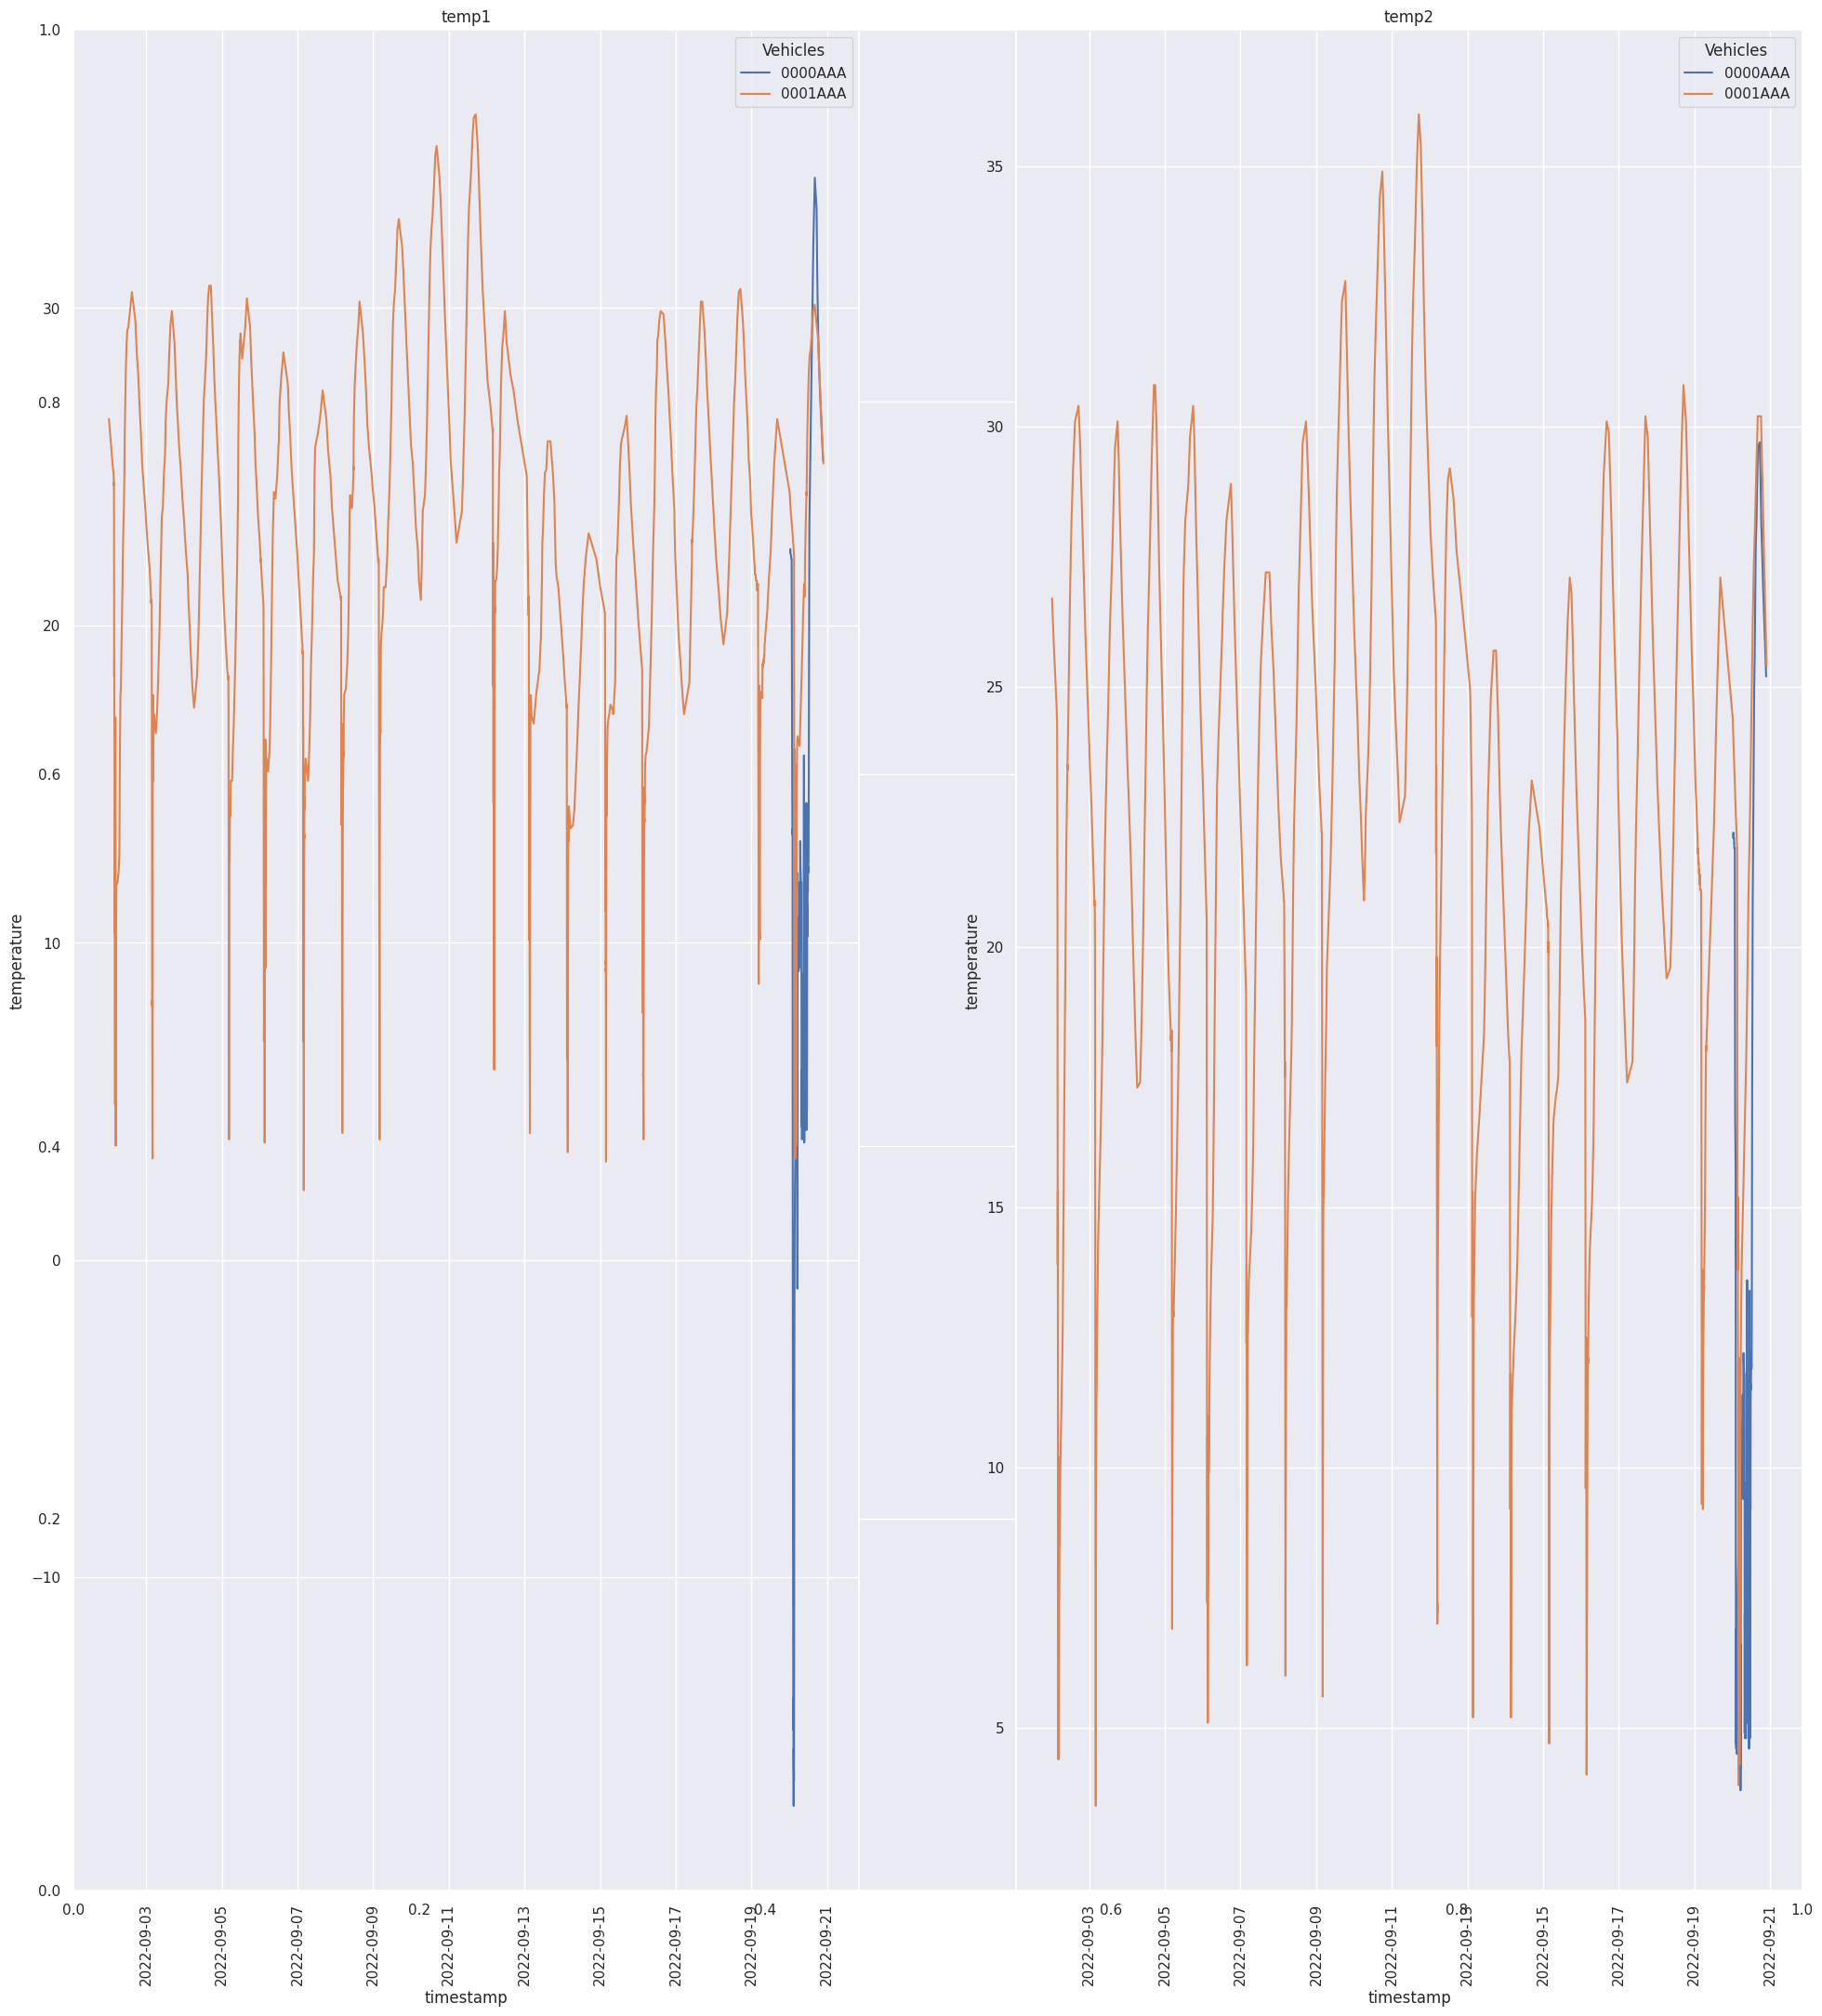

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
gs = plt.GridSpec(1,2)

#Left plot.
ax = fig.add_subplot(gs[0,0])
sns.set(rc={"figure.figsize":(24, 6)}) 
ax = sns.lineplot(data=main_df, 
                  x="timestamp", 
                  y="temp1", 
                  hue="vehicle_plate",
                  legend=True
                  )
plt.title("temp1")
plt.xticks(rotation=90)
plt.ylabel("temperature")
plt.legend(title="Vehicles")

# Right plot.
ax = fig.add_subplot(gs[0,1])
sns.set(rc={"figure.figsize":(24, 26)}) 
ax = sns.lineplot(data=main_df, 
                  x="timestamp", 
                  y="temp2", 
                  hue="vehicle_plate",
                  legend=True
                  )
plt.title("temp2")
plt.xticks(rotation=90)
plt.ylabel("temperature")
plt.legend(title="Vehicles")

__Conclusion__: We observed a seasonal pattern that we can analyse in greater depth by day of the week and time of day.
It is clear that the data from vehicle 0000AAA is not sufficient to carry out a study of patterns. Hence, from this point we will **only** be working with the vehicle 0001AAA.



In [16]:
df_00001AAA = main_df[main_df["vehicle_plate"]=="0001AAA"]
df_00001AAA.reset_index(inplace=True, drop=True)

# Comparing temp1 and temp2 for one vehicle
---

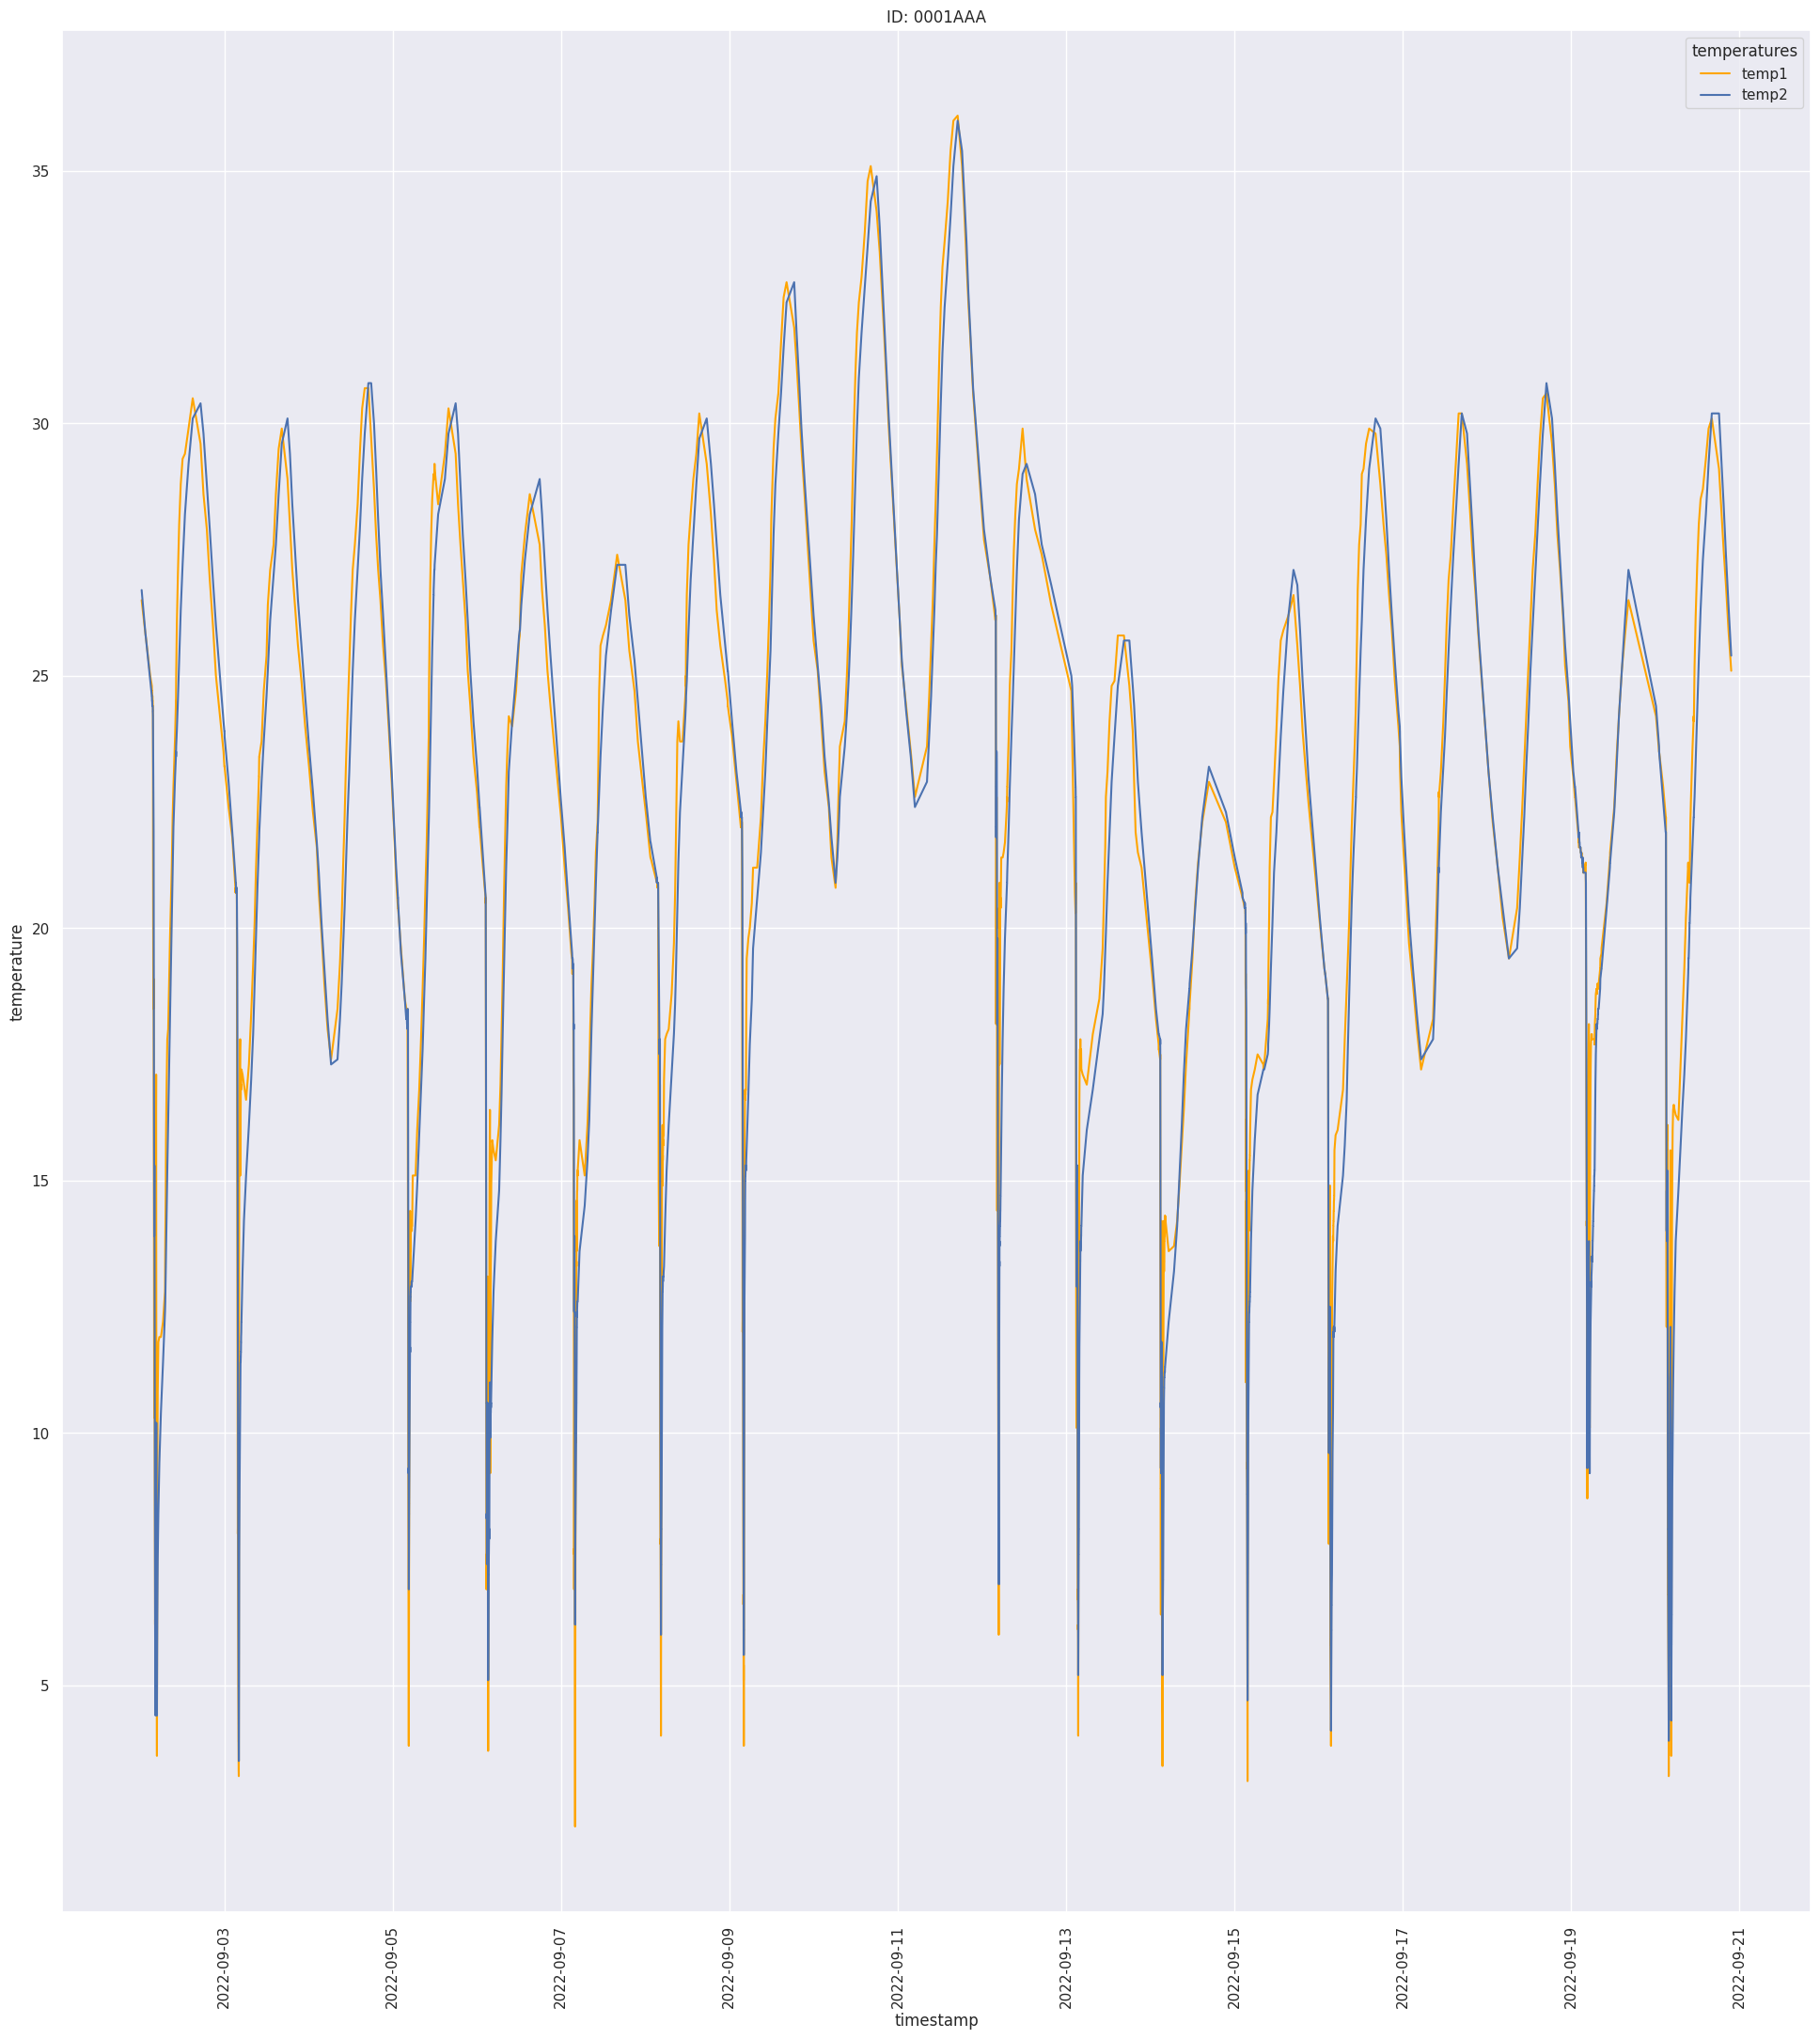

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sns.set(rc={"figure.figsize":(24, 6)}) 
ax = sns.lineplot(data=df_00001AAA, 
                    x="timestamp", 
                    y="temp1", 
                    label="temp1",
                    legend=True, 
                    color="orange"
                    )
ax = sns.lineplot(data=df_00001AAA, 
                    x="timestamp", 
                    y="temp2", 
                    label="temp2",
                    legend=True
                    )
            
plt.title("ID: 0001AAA")
plt.xticks(rotation=90)
plt.ylabel("temperature")
plt.legend(title="temperatures")

**Conclusion:** The values for temp1 and temp2 are very closely related, with temp1 registering changes in temperature first. The correlation between temp 1 and temp2 are clear (0.77 for 0000AAA; 0.92 for 0001AAA), as observed in the file EDA_1_data_analysis.

# Counting events by days/hours
---

Checking if days and hours are correlated to the volume of entries.



In [32]:
import plotly.express as px
import matplotlib.pyplot as plt

df_counts = pd.DataFrame()
df_daily = pd.DataFrame()

# Group data logs by date and day of week in order to calculate size and percentage.
df_counts["event_number"] = df_00001AAA.groupby(by=["date", "day_of_week"]).size()
df_counts["event_%"] = round(df_counts["event_number"]/df_counts["event_number"].sum()*100,1)

# Resampling our data by day
df_daily = df_00001AAA.resample("D", on="timestamp").count()

print(df_counts)

# Plot an histogram
fig = px.histogram(df_daily, 
                   x=df_daily.index, 
                   y="temp1",
                   nbins=len(df_daily),
                   text_auto=True,
                   template="seaborn",
                   title="Num. entries per day",
                   )
fig.update_layout(xaxis_title_text="Days")
fig.show()


                        event_number  event_%
date       day_of_week                       
2022-09-02 Friday                408      6.4
2022-09-03 Saturday              415      6.5
2022-09-04 Sunday                 33      0.5
2022-09-05 Monday                432      6.7
2022-09-06 Tuesday               385      6.0
2022-09-07 Wednesday             405      6.3
2022-09-08 Thursday              446      7.0
2022-09-09 Friday                429      6.7
2022-09-10 Saturday               30      0.5
2022-09-11 Sunday                 27      0.4
2022-09-12 Monday                403      6.3
2022-09-13 Tuesday               400      6.2
2022-09-14 Wednesday             371      5.8
2022-09-15 Thursday              412      6.4
2022-09-16 Friday                431      6.7
2022-09-17 Saturday               38      0.6
2022-09-18 Sunday                 26      0.4
2022-09-19 Monday                789     12.3
2022-09-20 Tuesday               531      8.3


In [30]:
# Create new dataframe
df_hour = pd.DataFrame()

# Group data logs by hour and calculate their size as number and percentage
df_hour["event_number"] = df_00001AAA.groupby(by=["hour"]).size()
df_hour["event_%"] = round(df_hour["event_number"]/df_hour["event_number"].sum()*100,1)
print(df_hour)

# Plot an histogram
fig = px.histogram(df_hour, 
                   x=df_hour.index, 
                   y="event_number",
                   nbins=len(df_hour),
                   text_auto=True,
                   template="seaborn",
                   title="Num. entries per hour",
                   )
fig.show()



      event_number  event_%
hour                       
0               45      0.7
1               99      1.5
2              521      8.1
3             2106     32.8
4             2090     32.6
5              523      8.2
6              164      2.6
7              150      2.3
8               76      1.2
9              152      2.4
10             116      1.8
11             109      1.7
12              52      0.8
13              21      0.3
14              18      0.3
15              17      0.3
16              13      0.2
17              11      0.2
18              18      0.3
19              25      0.4
20              22      0.3
21              17      0.3
22               7      0.1
23              39      0.6


__Conclusion__: We observed seasonality related to working days, with more entries from Monday to Friday, but some exceptions on Saturdays. The volume of data received each working day is similar.
When analysing hours in the day, we detected that the majority of values (80%) are recorded between 02:00 and 06:00.

# Searching for daily patterns
---

In [29]:
import plotly.express as px

fig = px.line(main_df, x="timestamp", y="temp1", color="day_of_week", facet_col="week_of_year")
fig.show()


__Conclusion__: When we observe the temperature readings within each day, we can confirm a pattern where there is a rapid decrease in temperature in the early hours followed by an increase during the rest of the day.

However, on weekends the temperature range is less pronounced, so we can incorporate weekends as a regressor in our model.

# Correlations: 
---

We looked for possible correlations in our database.



Text(0.5, 1.0, 'Dataframe2 - 0001AAA')

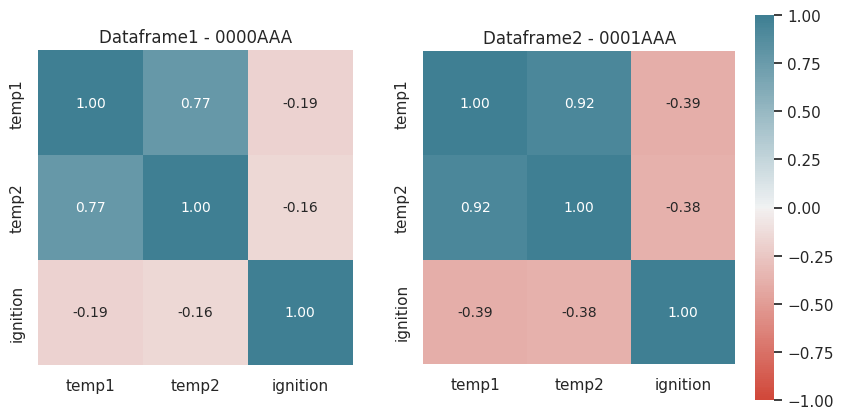

In [34]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

# Prepare a dataframe for each vehicle:
dataframe1 = main_df[main_df["vehicle_plate"]=="0000AAA"]
dataframe2 = main_df[main_df["vehicle_plate"]=="0001AAA"]

# Columns to include when looking for correleations.
columns = ["temp1", "temp2", "ignition"]

# Generate the structure for two graphs and adjust sizes.
fig, axs = plt.subplots(ncols=2, width_ratios=[25,31], figsize=(10,5))


# Calculate the correlations for each dataframe.
corr_df1 = np.corrcoef(dataframe1[columns].values.T)
corr_df2 = np.corrcoef(dataframe2[columns].values.T)

# Plot graphs for each dataframe.
sns.set(font_scale=1)
sns.heatmap(corr_df1, 
            cbar=False, 
            annot=True, 
            square=True,
            fmt=".2f",
            vmin=-1,
            vmax=1,
            cmap = sns.diverging_palette(15, 220, n=200), 
            annot_kws={"size":10}, 
            yticklabels=columns,
            ax=axs[0], 
            xticklabels=columns)

sns.heatmap(corr_df2, 
            cbar=True, 
            annot=True, 
            square=True,
            fmt=".2f",
            vmin=-1,
            vmax=1,
            cmap = sns.diverging_palette(15, 220, n=200), 
            annot_kws={"size":10}, 
            yticklabels=columns,
            ax=axs[1], 
            xticklabels=columns)

# Title edition
axs[0].set_title("Dataframe1 - 0000AAA")
axs[1].set_title("Dataframe2 - 0001AAA")

__Conclusion__: We observed a strong correlation between attributes 'temp1' and 'temp2' for each vehicle (higher in the second set of data, which contains more entries).

The correlation between 'ignition' and the 'temp1' and 'temp2' attributes is less clear. We will determine if using these attributes as regressors in our model contributes any value when making predictions.
